In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications import MobileNetV3Small

from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from time import perf_counter, sleep

import tensorflow_addons as tfa


In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  rotation_range=120, 
                                  horizontal_flip = True,)
# width_shift_range=[-150, 150] 사진 자르기 ---- height_shift_range=[-150, 150] 높이 기준으로 자르기
# rotation_range=120 회전하기 ---- brightness_range=[0.1, 1.5] 색 바꾸기 0.1은 10%
# zoom_range=[0.3, 1.5] 확대 ---- shear_range=50 좌우 늘리기
print("start")

test_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training and test sets
train_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/train',
                                                #  target_size = (224,224),
                                                target_size = (299,299),
                                                batch_size = 16,
                                                #  batch_size = 128,
                                                class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/test',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 16,
                                            # batch_size = 128,
                                            class_mode = 'categorical')

val_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/val',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 16,
                                            # batch_size = 128,
                                            class_mode = 'categorical')
print("end")


start
Found 221 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
end


In [ ]:
# Load the InceptionResNetV2 model with pre-trained weights

input_tensor = tf.keras.layers.Input(shape=(299, 299, 3))
base_model = InceptionResNetV2(weights='imagenet', include_top=False,input_tensor=input_tensor)

# Freeze the layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Add a GlobalAveragePooling layer
x = base_model.output
# x = GlobalMaxPooling2D()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(8, activation='softmax',)(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    
    metrics=['accuracy',
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall(),
              tfa.metrics. F1Score(num_classes = 8,
                                  average='macro')]
)
print("1")

1


In [ ]:
# Train the model on the data
# Validation_data – 모델에 대한 손실 평가 및 메트릭에 대해 고려할 데이터입니다.
# Class_weight - 는 클래스의 사전 인덱스를 손실 함수 계산에 추가로 사용되는 해당 float 또는 weight 값으로 매핑하기 위한 선택적 매개변수입니다.
start = perf_counter()
history = model.fit_generator(train_set, epochs = 9, validation_data = val_set)
end = perf_counter()
print(f"Time : {end-start}")

<ipython-input-56-4de78d554307>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set, epochs = 9, validation_data = val_set)


Epoch 1/9


ValueError: ignored

In [ ]:
model.save(r'/content/drive/MyDrive/모델저장/InceprionResnetV2_epoch_9_batch_16.h5')

## Test Set

In [ ]:
# Evaluate the model on the test set
result= model.evaluate_generator(test_set) 

<ipython-input-55-e155823641e8>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result= model.evaluate_generator(test_set)


ValueError: ignored

In [ ]:
print('loss:', round(result[0], 5))
print('accuracy:', round(result[1], 5))
print('precision:', round(result[2], 5))
print('recall:', round(result[3], 5))
print('f1-score:', round(result[4], 5))

# loss: 0.43365
# accuracy: 0.84932
# precision: 0.84932
# recall: 0.84932
# f1-score: 0.85642

loss: 0.3015
accuracy: 0.90411
precision: 0.92857
recall: 0.89041
f1-score: 0.90273


## Graph

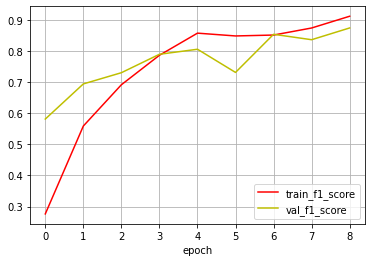

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history[str(list(history.history.keys())[4])] , "r", label='train_f1_score')
plt.plot(history.history[str(list(history.history.keys())[9])] , "y", label='val_f1_score')

plt.xlabel('epoch')

plt.legend(loc='lower right')
plt.grid()
plt.show()

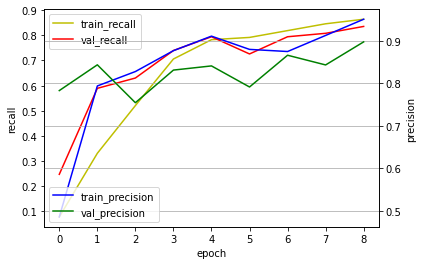

In [ ]:

fig, f1 = plt.subplots()

prec = f1.twinx()

f1.plot(history.history[str(list(history.history.keys())[3])], 'y', label='train_recall') #3
f1.plot(history.history[str(list(history.history.keys())[8])], 'r', label='val_recall') #8

prec.plot(history.history[str(list(history.history.keys())[2])], 'b', label='train_precision') #2
prec.plot(history.history[str(list(history.history.keys())[7])], 'g', label='val_precision') #-3

f1.set_xlabel('epoch')
f1.set_ylabel('recall')
prec.set_ylabel('precision')

f1.legend(loc='upper left')
prec.legend(loc='lower left')

plt.grid()
plt.show()

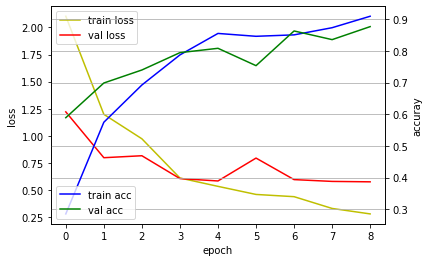

In [ ]:
import matplotlib.pyplot as plt
fig, loss = plt.subplots()

acc = loss.twinx()

loss.plot(history.history[str(list(history.history.keys())[0])], 'y', label='train loss') #3
loss.plot(history.history[str(list(history.history.keys())[5])], 'r', label='val loss') #8

acc.plot(history.history[str(list(history.history.keys())[1])], 'b', label='train acc') #2
acc.plot(history.history[str(list(history.history.keys())[6])], 'g', label='val acc') #-3

loss.set_xlabel('epoch')
loss.set_ylabel('loss')
acc.set_ylabel('accuray')

loss.legend(loc='upper left')
acc.legend(loc='lower left')

plt.grid()
plt.show()

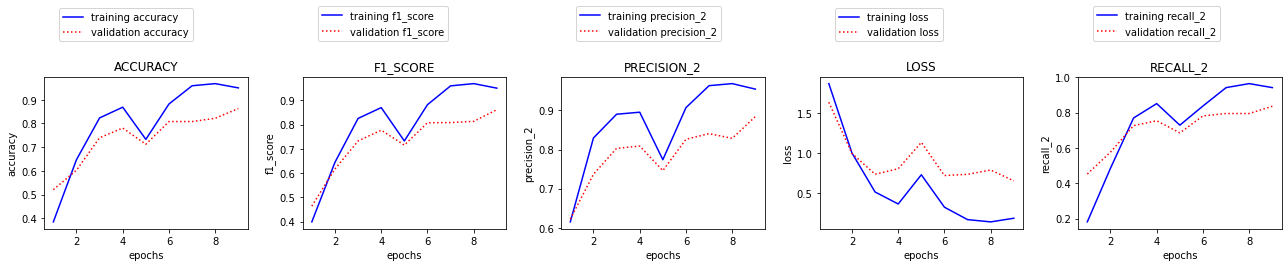

In [ ]:
key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
plt.figure(figsize=(18, 4))
for idx , key in enumerate(key_value) :
    plt.subplot(1, len(key_value), idx+1)

    plt.title(f"{key.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{key.lower()}")
    value = history.history.get(key)
    val_value = history.history.get(f"val_{key}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {key}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {key}')
    plt.legend(loc='lower left', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

plt.tight_layout()
plt.show()

# **Try2**

#### 배치사이즈 변경 16 -> 32

In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.6,
                                  rotation_range=120, 
                                   height_shift_range = 0.2,
                                  width_shift_range=[-30, 30],
                                  horizontal_flip = True,)
# width_shift_range=[-150, 150] 사진 자르기 ---- height_shift_range=[-150, 150] 높이 기준으로 자르기
# rotation_range=120 회전하기 ---- brightness_range=[0.1, 1.5] 색 바꾸기 0.1은 10%
# zoom_range=[0.3, 1.5] 확대 ---- shear_range=50 좌우 늘리기
print("start")

test_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training and test sets
train_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/train',
                                                #  target_size = (224,224),
                                                target_size = (299,299),
                                                batch_size = 32,
                                                #  batch_size = 128,
                                                class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/test',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 32,
                                            # batch_size = 128,
                                            class_mode = 'categorical')

val_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/val',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 32,
                                            # batch_size = 128,
                                            class_mode = 'categorical')
print("end")


start
Found 221 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
end


In [ ]:
# train_set, test_set, val_set = augumentation(299, 32)

# Load the InceptionResNetV2 model with pre-trained weights
input_tensor = tf.keras.layers.Input(shape=(299, 299, 3))
base_model = InceptionResNetV2(weights='imagenet', include_top=False,input_tensor=input_tensor)

# Freeze the layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Add a GlobalAveragePooling layer
x = base_model.output
# x = GlobalMaxPooling2D()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(8, activation='softmax',)(x)

# Compile the model
model = Model(inputs = base_model.input, outputs=predictions)
model.compile(
    optimizer= "adam",
    loss='categorical_crossentropy',
    metrics=['accuracy',
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall(),
              tfa.metrics. F1Score(num_classes = 8, average='macro')]
      ) 

In [ ]:
# Train the model on the data
# Validation_data – 모델에 대한 손실 평가 및 메트릭에 대해 고려할 데이터입니다.
# Class_weight - 는 클래스의 사전 인덱스를 손실 함수 계산에 추가로 사용되는 해당 float 또는 weight 값으로 매핑하기 위한 선택적 매개변수입니다.
start = perf_counter()
history = model.fit_generator( train_set, epochs = 9, validation_data = val_set )
end = perf_counter()
print(f"Time : {end-start}")

<ipython-input-40-c389703341c9>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator( train_set, epochs = 9, validation_data = val_set )


Epoch 1/9
7/7 [==============================] - 27s 2s/step - loss: 2.1038 - accuracy: 0.2851 - precision_3: 0.4857 - recall_3: 0.0769 - f1_score: 0.2765 - val_loss: 1.2209 - val_accuracy: 0.5890 - val_precision_3: 0.7826 - val_recall_3: 0.2466 - val_f1_score: 0.5814
Epoch 2/9
7/7 [==============================] - 13s 2s/step - loss: 1.1982 - accuracy: 0.5747 - precision_3: 0.7935 - recall_3: 0.3303 - f1_score: 0.5590 - val_loss: 0.7977 - val_accuracy: 0.6986 - val_precision_3: 0.8431 - val_recall_3: 0.5890 - val_f1_score: 0.6944
Epoch 3/9
7/7 [==============================] - 12s 2s/step - loss: 0.9723 - accuracy: 0.6923 - precision_3: 0.8273 - recall_3: 0.5204 - f1_score: 0.6917 - val_loss: 0.8159 - val_accuracy: 0.7397 - val_precision_3: 0.7541 - val_recall_3: 0.6301 - val_f1_score: 0.7305
Epoch 4/9
7/7 [==============================] - 12s 2s/step - loss: 0.6103 - accuracy: 0.7873 - precision_3: 0.8764 - recall_3: 0.7059 - f1_score: 0.7865 - val_loss: 0.6049 - val_accuracy: 0.7

In [ ]:
model.save(r'/content/drive/MyDrive/모델저장/InceprionResnetV2_epoch_9_batch_32.h5')

## Test Set

In [ ]:
# Evaluate the model on the test set
result= model.evaluate_generator(test_set) 

<ipython-input-42-e155823641e8>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result= model.evaluate_generator(test_set)


In [ ]:
print('loss:', round(result[0], 5))
print('accuracy:', round(result[1], 5))
print('precision:', round(result[2], 5))
print('recall:', round(result[3], 5))
print('f1-score:', round(result[4], 5))

loss: 0.32308
accuracy: 0.86301
precision: 0.93939
recall: 0.84932
f1-score: 0.85408


## Graph

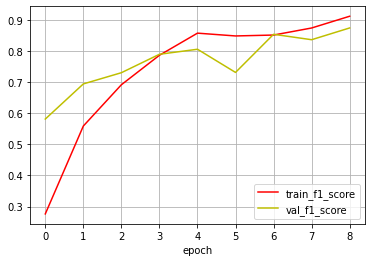

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history[str(list(history.history.keys())[4])] , "r", label='train_f1_score')
plt.plot(history.history[str(list(history.history.keys())[9])] , "y", label='val_f1_score')

plt.xlabel('epoch')

plt.legend(loc='lower right')
plt.grid()
plt.show()

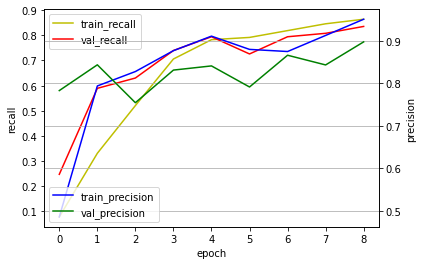

In [ ]:

fig, f1 = plt.subplots()

prec = f1.twinx()

f1.plot(history.history[str(list(history.history.keys())[3])], 'y', label='train_recall') #3
f1.plot(history.history[str(list(history.history.keys())[8])], 'r', label='val_recall') #8

prec.plot(history.history[str(list(history.history.keys())[2])], 'b', label='train_precision') #2
prec.plot(history.history[str(list(history.history.keys())[7])], 'g', label='val_precision') #-3

f1.set_xlabel('epoch')
f1.set_ylabel('recall')
prec.set_ylabel('precision')

f1.legend(loc='upper left')
prec.legend(loc='lower left')

plt.grid()
plt.show()

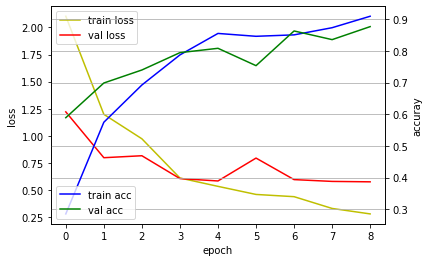

In [ ]:
import matplotlib.pyplot as plt
fig, loss = plt.subplots()

acc = loss.twinx()

loss.plot(history.history[str(list(history.history.keys())[0])], 'y', label='train loss') #3
loss.plot(history.history[str(list(history.history.keys())[5])], 'r', label='val loss') #8

acc.plot(history.history[str(list(history.history.keys())[1])], 'b', label='train acc') #2
acc.plot(history.history[str(list(history.history.keys())[6])], 'g', label='val acc') #-3

loss.set_xlabel('epoch')
loss.set_ylabel('loss')
acc.set_ylabel('accuray')

loss.legend(loc='upper left')
acc.legend(loc='lower left')

plt.grid()
plt.show()

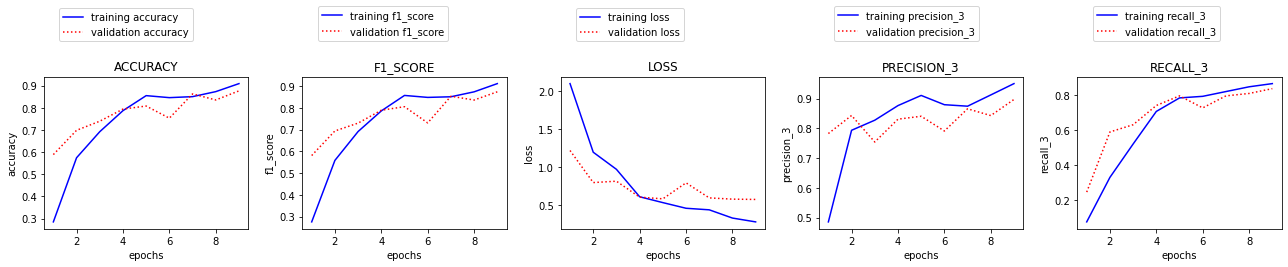

In [ ]:
key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
plt.figure(figsize=(18, 4))
for idx , key in enumerate(key_value) :
    plt.subplot(1, len(key_value), idx+1)

    plt.title(f"{key.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{key.lower()}")
    value = history.history.get(key)
    val_value = history.history.get(f"val_{key}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {key}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {key}')
    plt.legend(loc='lower left', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

plt.tight_layout()
plt.show()

In [ ]:
d

NameError: ignored



---



---



# Try3

#### 에포크 20

In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  rotation_range=120, 
                                  horizontal_flip = True,)
# width_shift_range=[-150, 150] 사진 자르기 ---- height_shift_range=[-150, 150] 높이 기준으로 자르기
# rotation_range=120 회전하기 ---- brightness_range=[0.1, 1.5] 색 바꾸기 0.1은 10%
# zoom_range=[0.3, 1.5] 확대 ---- shear_range=50 좌우 늘리기
print("start")

test_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training and test sets
train_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/train',
                                                #  target_size = (224,224),
                                                target_size = (299,299),
                                                batch_size = 32,
                                                #  batch_size = 128,
                                                class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/test',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 32,
                                            # batch_size = 128,
                                            class_mode = 'categorical')

val_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/val',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 32,
                                            # batch_size = 128,
                                            class_mode = 'categorical')
print("end")


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  rotation_range=120, 
                                  horizontal_flip = True,)
# width_shift_range=[-150, 150] 사진 자르기 ---- height_shift_range=[-150, 150] 높이 기준으로 자르기
# rotation_range=120 회전하기 ---- brightness_range=[0.1, 1.5] 색 바꾸기 0.1은 10%
# zoom_range=[0.3, 1.5] 확대 ---- shear_range=50 좌우 늘리기
print("start")

test_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training and test sets
train_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/train',
                                                #  target_size = (224,224),
                                                target_size = (299,299),
                                                batch_size = 32,
                                                #  batch_size = 128,
                                                class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/test',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 32,
                                            # batch_size = 128,
                                            class_mode = 'categorical')

val_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/val',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 32,
                                            # batch_size = 128,
                                            class_mode = 'categorical')
print("end")

In [ ]:
# train_set, test_set, val_set = augumentation(299, 32)

# Load the InceptionResNetV2 model with pre-trained weights
input_tensor = tf.keras.layers.Input(shape=(299, 299, 3))
base_model = InceptionResNetV2(weights='imagenet', include_top=False,input_tensor=input_tensor)

# Freeze the layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Add a GlobalAveragePooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(8, activation='softmax',)(x)

# Compile the model
model = Model(inputs = base_model.input, outputs=predictions)
model.compile(
    optimizer= Adam(lr = 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall(),
              tfa.metrics. F1Score(num_classes = 8, average='macro')]
      ) 

In [ ]:
# Train the model on the data
# Validation_data – 모델에 대한 손실 평가 및 메트릭에 대해 고려할 데이터입니다.
# Class_weight - 는 클래스의 사전 인덱스를 손실 함수 계산에 추가로 사용되는 해당 float 또는 weight 값으로 매핑하기 위한 선택적 매개변수입니다.
start = perf_counter()
history = model.fit_generator( train_set, epochs = 13, validation_data = val_set )
end = perf_counter()
print(f"Time : {end-start}")

In [ ]:
# model.save(r'/content/d/rive/MyDrive/모델저장/InceprionResnetV2_epoch_15_batch_16.h5')

## Test Set

In [ ]:
# Evaluate the model on the test set
result= model.evaluate_generator(test_set) 

In [ ]:
print('loss:', round(result[0], 5))
print('accuracy:', round(result[1], 5))
print('precision:', round(result[2], 5))
print('recall:', round(result[3], 5))
print('f1-score:', round(result[4], 5))

## Graph

In [ ]:
list(history.history.keys())[4]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history[str(list(history.history.keys())[4])] , "r", label='train_f1_score')
plt.plot(history.history[str(list(history.history.keys())[9])] , "y", label='val_f1_score')

plt.xlabel('epoch')

plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:

fig, f1 = plt.subplots()

prec = f1.twinx()

f1.plot(history.history[str(list(history.history.keys())[3])], 'y', label='train_recall') #3
f1.plot(history.history[str(list(history.history.keys())[8])], 'r', label='val_recall') #8

prec.plot(history.history[str(list(history.history.keys())[2])], 'b', label='train_precision') #2
prec.plot(history.history[str(list(history.history.keys())[7])], 'g', label='val_precision') #-3

f1.set_xlabel('epoch')
f1.set_ylabel('recall')
prec.set_ylabel('precision')

f1.legend(loc='upper left')
prec.legend(loc='lower left')

plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig, loss = plt.subplots()

acc = loss.twinx()

loss.plot(history.history[str(list(history.history.keys())[0])], 'y', label='train loss') #3
loss.plot(history.history[str(list(history.history.keys())[5])], 'r', label='val loss') #8

acc.plot(history.history[str(list(history.history.keys())[1])], 'b', label='train acc') #2
acc.plot(history.history[str(list(history.history.keys())[6])], 'g', label='val acc') #-3

loss.set_xlabel('epoch')
loss.set_ylabel('loss')
acc.set_ylabel('accuray')

loss.legend(loc='upper left')
acc.legend(loc='lower left')

plt.grid()
plt.show()

In [ ]:
key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
plt.figure(figsize=(18, 4))
for idx , key in enumerate(key_value) :
    plt.subplot(1, len(key_value), idx+1)

    plt.title(f"{key.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{key.lower()}")
    value = history.history.get(key)
    val_value = history.history.get(f"val_{key}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {key}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {key}')
    plt.legend(loc='lower left', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

plt.tight_layout()
plt.show()